### This notebook generate the line benefits from the operational cost

In [664]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [665]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data, cluster_type):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    if cluster_type == 'hourly':
        table = table.set_index(['LoadLevel', 'Day', 'Month', 'Segment K-medoids PCA'])
    elif cluster_type == 'daily with hourly resolution':
        table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    elif cluster_type == 'weekly with hourly resolution':
        table = table.set_index(['Week', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data, cluster_type):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    # df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    if cluster_type == 'hourly':
        table = table.set_index(['LoadLevel', 'Day', 'Month', 'Segment K-medoids PCA'])
    elif cluster_type == 'daily with hourly resolution':
        table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    elif cluster_type == 'weekly with hourly resolution':
        table = table.set_index(['Week', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    # data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(os.path.join(_path_1, '2.Par', 'oT_Data_Duration_' + CaseName_1 + '.csv'), sep=',', index=False)
    # dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(os.path.join(_path_1, '2.Par', 'oT_Data_Stage_' + CaseName_1 + '.csv'), sep=',')
    # dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(os.path.join(_path_1, '1.Set', 'oT_Dict_Stage_' + CaseName_1 + '.csv'), sep=',', index=False)
    # dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [666]:
#%% Setting up the path a cases
DirName  = os.getcwd()

opt_cluster = 100

CaseName_Base     = 'RTS24'
# CaseName_ByStages = CaseName_Base+'_ByStages'
CaseName_ByStages = CaseName_Base+'_ByStages_nc'+str(opt_cluster)

CSV_name =  'oT_LineBenefit_Data_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

#%% type of clustering  ('hourly'; 'daily with hourly resolution'; 'weekly with hourly resolution')
clustering_type = 'hourly'

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [667]:
df_1 = pd.read_csv(_path_0+'/3.Out'+'/'+CSV_name+'.csv', index_col=0)
diff_df_1 = df_1

In [668]:
diff_df_1

,N_101_N_102_cac1,N_101_N_103_cac1,N_101_N_105_cac1,N_102_N_104_cac1,N_102_N_106_cac1,N_103_N_109_cac1,N_103_N_124_cac1,N_104_N_109_cac1,N_105_N_110_cac1,N_106_N_108_cac1,...,N_116_N_119_cac1,N_117_N_118_cac1,N_117_N_122_cac1,N_118_N_121_cac1,N_118_N_121_cac2,N_119_N_120_cac1,N_119_N_120_cac2,N_120_N_123_cac1,N_120_N_123_cac2,N_121_N_122_cac1
0,-0.000264,-0.036063,0.001626,0.001200,0.001340,-0.018041,-0.113191,0.002424,0.005860,-0.001572,...,0.023738,0.284233,0.459841,0.322689,0.322689,0.009346,0.009346,0.003557,0.003557,-0.269681
1,-0.000264,-0.036100,0.001627,0.001200,0.001339,-0.018079,-0.113306,0.002426,0.005863,-0.001572,...,0.023759,0.284406,0.459901,0.322902,0.322902,0.009355,0.009355,0.003561,0.003561,-0.269647
2,-0.000271,-0.036919,0.001631,0.001217,0.001338,-0.018937,-0.115904,0.002463,0.005934,-0.001571,...,0.024230,0.288292,0.461248,0.327706,0.327706,0.009555,0.009555,0.003644,0.003644,-0.268884
3,-0.000369,-0.049831,0.002135,0.001622,0.001739,-0.026453,-0.155786,0.003291,0.007891,-0.002030,...,0.032513,0.312682,0.480108,0.354093,0.354093,0.012788,0.012788,0.004867,0.004867,-0.347150
4,-0.000377,-0.052294,0.002579,0.001815,0.002160,-0.023122,-0.163224,0.003645,0.008923,-0.002018,...,0.027032,0.365039,0.601821,0.449968,0.449968,0.009226,0.009226,0.002760,0.002760,-0.348249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,-0.001136,-0.099068,0.003696,0.003317,0.002319,-0.068806,-0.440865,0.007033,0.015882,-0.001826,...,0.070307,1.048977,0.991815,0.842684,0.842684,0.017267,0.017267,0.005722,0.005722,-0.548519
8732,-0.001176,-0.090849,0.003380,0.003269,0.001672,-0.057381,-0.214976,0.006883,0.015237,-0.001656,...,0.072182,1.061641,0.992311,0.838431,0.838431,0.018529,0.018529,0.006499,0.006499,-0.385792
8733,-0.000377,-0.052261,0.002573,0.001813,0.002154,-0.023167,-0.163123,0.003640,0.008909,-0.002019,...,0.027106,0.365415,0.601848,0.449877,0.449877,0.009274,0.009274,0.002789,0.002789,-0.348234
8734,-0.000369,-0.050007,0.002167,0.001636,0.001769,-0.026215,-0.156318,0.003316,0.007965,-0.002029,...,0.032121,0.350197,0.516439,0.392036,0.392036,0.012534,0.012534,0.004717,0.004717,-0.347228


In [669]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [670]:
diff_df_1.head()

,N_101_N_102_cac1,N_101_N_103_cac1,N_101_N_105_cac1,N_102_N_104_cac1,N_102_N_106_cac1,N_103_N_109_cac1,N_103_N_124_cac1,N_104_N_109_cac1,N_105_N_110_cac1,N_106_N_108_cac1,...,N_116_N_119_cac1,N_117_N_118_cac1,N_117_N_122_cac1,N_118_N_121_cac1,N_118_N_121_cac2,N_119_N_120_cac1,N_119_N_120_cac2,N_120_N_123_cac1,N_120_N_123_cac2,N_121_N_122_cac1
0,-0.000264,-0.036063,0.001626,0.001200,0.001340,-0.018041,-0.113191,0.002424,0.005860,-0.001572,...,0.023738,0.284233,0.459841,0.322689,0.322689,0.009346,0.009346,0.003557,0.003557,-0.269681
1,-0.000264,-0.036100,0.001627,0.001200,0.001339,-0.018079,-0.113306,0.002426,0.005863,-0.001572,...,0.023759,0.284406,0.459901,0.322902,0.322902,0.009355,0.009355,0.003561,0.003561,-0.269647
2,-0.000271,-0.036919,0.001631,0.001217,0.001338,-0.018937,-0.115904,0.002463,0.005934,-0.001571,...,0.024230,0.288292,0.461248,0.327706,0.327706,0.009555,0.009555,0.003644,0.003644,-0.268884
3,-0.000369,-0.049831,0.002135,0.001622,0.001739,-0.026453,-0.155786,0.003291,0.007891,-0.002030,...,0.032513,0.312682,0.480108,0.354093,0.354093,0.012788,0.012788,0.004867,0.004867,-0.347150
4,-0.000377,-0.052294,0.002579,0.001815,0.002160,-0.023122,-0.163224,0.003645,0.008923,-0.002018,...,0.027032,0.365039,0.601821,0.449968,0.449968,0.009226,0.009226,0.002760,0.002760,-0.348249


In [671]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [672]:
diff_df_1.head()

,N_101_N_102_cac1,N_101_N_103_cac1,N_101_N_105_cac1,N_102_N_104_cac1,N_102_N_106_cac1,N_103_N_109_cac1,N_103_N_124_cac1,N_104_N_109_cac1,N_105_N_110_cac1,N_106_N_108_cac1,...,N_116_N_119_cac1,N_117_N_118_cac1,N_117_N_122_cac1,N_118_N_121_cac1,N_118_N_121_cac2,N_119_N_120_cac1,N_119_N_120_cac2,N_120_N_123_cac1,N_120_N_123_cac2,N_121_N_122_cac1
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,-0.000264,-0.036063,0.001626,0.001200,0.001340,-0.018041,-0.113191,0.002424,0.005860,-0.001572,...,0.023738,0.284233,0.459841,0.322689,0.322689,0.009346,0.009346,0.003557,0.003557,-0.269681
01-01 01:00:00+01:00,-0.000264,-0.036100,0.001627,0.001200,0.001339,-0.018079,-0.113306,0.002426,0.005863,-0.001572,...,0.023759,0.284406,0.459901,0.322902,0.322902,0.009355,0.009355,0.003561,0.003561,-0.269647
01-01 02:00:00+01:00,-0.000271,-0.036919,0.001631,0.001217,0.001338,-0.018937,-0.115904,0.002463,0.005934,-0.001571,...,0.024230,0.288292,0.461248,0.327706,0.327706,0.009555,0.009555,0.003644,0.003644,-0.268884
01-01 03:00:00+01:00,-0.000369,-0.049831,0.002135,0.001622,0.001739,-0.026453,-0.155786,0.003291,0.007891,-0.002030,...,0.032513,0.312682,0.480108,0.354093,0.354093,0.012788,0.012788,0.004867,0.004867,-0.347150
01-01 04:00:00+01:00,-0.000377,-0.052294,0.002579,0.001815,0.002160,-0.023122,-0.163224,0.003645,0.008923,-0.002018,...,0.027032,0.365039,0.601821,0.449968,0.449968,0.009226,0.009226,0.002760,0.002760,-0.348249


In [673]:
ddf_1 = diff_df_1.stack()

In [674]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [675]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [676]:
ddf_1.head()

Value
LoadLevel            Execution                 
01-01 00:00:00+01:00 N_101_N_102_cac1 -0.000264
                     N_101_N_103_cac1 -0.036063
                     N_101_N_105_cac1  0.001626
                     N_102_N_104_cac1  0.001200
                     N_102_N_106_cac1  0.001340

In [677]:
ddf_1 = ddf_1.reset_index()

In [678]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [679]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [680]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
340699,12-30 23:00:00+01:00,N_119_N_120_cac1,0.009431,1900-12-30 23:00:00
340700,12-30 23:00:00+01:00,N_119_N_120_cac2,0.009431,1900-12-30 23:00:00
340701,12-30 23:00:00+01:00,N_120_N_123_cac1,0.003592,1900-12-30 23:00:00
340702,12-30 23:00:00+01:00,N_120_N_123_cac2,0.003592,1900-12-30 23:00:00
340703,12-30 23:00:00+01:00,N_121_N_122_cac1,-0.269359,1900-12-30 23:00:00


#### Getting day of year and month

In [681]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [682]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,N_101_N_102_cac1,-0.000264,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,N_101_N_103_cac1,-0.036063,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,N_101_N_105_cac1,0.001626,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,N_102_N_104_cac1,0.001200,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,N_102_N_106_cac1,0.001340,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [683]:
if clustering_type == 'hourly':
    ddf_1['Variable'] = ddf_1['Execution']
elif clustering_type == 'daily with hourly resolution':
    ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)
elif clustering_type == 'weekly with hourly resolution':
    ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)


In [684]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
340699,12-30 23:00:00+01:00,N_119_N_120_cac1,0.009431,1900-12-30 23:00:00,23,364,52,12,N_119_N_120_cac1
340700,12-30 23:00:00+01:00,N_119_N_120_cac2,0.009431,1900-12-30 23:00:00,23,364,52,12,N_119_N_120_cac2
340701,12-30 23:00:00+01:00,N_120_N_123_cac1,0.003592,1900-12-30 23:00:00,23,364,52,12,N_120_N_123_cac1
340702,12-30 23:00:00+01:00,N_120_N_123_cac2,0.003592,1900-12-30 23:00:00,23,364,52,12,N_120_N_123_cac2
340703,12-30 23:00:00+01:00,N_121_N_122_cac1,-0.269359,1900-12-30 23:00:00,23,364,52,12,N_121_N_122_cac1


In [685]:
if clustering_type == 'hourly':
    table = pd.pivot_table(ddf_1, values='Value', index=['LoadLevel', 'Month', 'Day'], columns=['Variable'], aggfunc=np.sum)
elif clustering_type == 'daily with hourly resolution':
    table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)
elif clustering_type == 'weekly with hourly resolution':
    table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Week'], columns=['Variable'], aggfunc=np.sum)


In [686]:
table.tail()

,,Variable,N_101_N_102_cac1,N_101_N_103_cac1,N_101_N_105_cac1,N_102_N_104_cac1,N_102_N_106_cac1,N_103_N_109_cac1,N_103_N_124_cac1,N_104_N_109_cac1,N_105_N_110_cac1,N_106_N_108_cac1,...,N_116_N_119_cac1,N_117_N_118_cac1,N_117_N_122_cac1,N_118_N_121_cac1,N_118_N_121_cac2,N_119_N_120_cac1,N_119_N_120_cac2,N_120_N_123_cac1,N_120_N_123_cac2,N_121_N_122_cac1
LoadLevel,Month,Day,,,,,,,,,,,,,,,,,,,,,
12-30 19:00:00+01:00,12,364,-0.001136,-0.099068,0.003696,0.003317,0.002319,-0.068806,-0.440865,0.007033,0.015882,-0.001826,...,0.070307,1.048977,0.991815,0.842684,0.842684,0.017267,0.017267,0.005722,0.005722,-0.548519
12-30 20:00:00+01:00,12,364,-0.001176,-0.090849,0.003380,0.003269,0.001672,-0.057381,-0.214976,0.006883,0.015237,-0.001656,...,0.072182,1.061641,0.992311,0.838431,0.838431,0.018529,0.018529,0.006499,0.006499,-0.385792
12-30 21:00:00+01:00,12,364,-0.000377,-0.052261,0.002573,0.001813,0.002154,-0.023167,-0.163123,0.003640,0.008909,-0.002019,...,0.027106,0.365415,0.601848,0.449877,0.449877,0.009274,0.009274,0.002789,0.002789,-0.348234
12-30 22:00:00+01:00,12,364,-0.000369,-0.050007,0.002167,0.001636,0.001769,-0.026215,-0.156318,0.003316,0.007965,-0.002029,...,0.032121,0.350197,0.516439,0.392036,0.392036,0.012534,0.012534,0.004717,0.004717,-0.347228
12-30 23:00:00+01:00,12,364,-0.000267,-0.036409,0.001628,0.001206,0.001339,-0.018403,-0.114288,0.002440,0.005890,-0.001572,...,0.023937,0.285874,0.460410,0.324717,0.324717,0.009431,0.009431,0.003592,0.003592,-0.269359


In [687]:
table = table.reset_index()

In [688]:
if clustering_type == 'hourly':
    table = table.set_index(['LoadLevel'])
elif clustering_type == 'daily with hourly resolution':
    table = table.set_index(['Day'])
elif clustering_type == 'weekly with hourly resolution':
    table = table.set_index(['Week'])

In [689]:
table.tail()

Variable,Month,Day,N_101_N_102_cac1,N_101_N_103_cac1,N_101_N_105_cac1,N_102_N_104_cac1,N_102_N_106_cac1,N_103_N_109_cac1,N_103_N_124_cac1,N_104_N_109_cac1,...,N_116_N_119_cac1,N_117_N_118_cac1,N_117_N_122_cac1,N_118_N_121_cac1,N_118_N_121_cac2,N_119_N_120_cac1,N_119_N_120_cac2,N_120_N_123_cac1,N_120_N_123_cac2,N_121_N_122_cac1
LoadLevel,,,,,,,,,,,,,,,,,,,,,
12-30 19:00:00+01:00,12,364,-0.001136,-0.099068,0.003696,0.003317,0.002319,-0.068806,-0.440865,0.007033,...,0.070307,1.048977,0.991815,0.842684,0.842684,0.017267,0.017267,0.005722,0.005722,-0.548519
12-30 20:00:00+01:00,12,364,-0.001176,-0.090849,0.003380,0.003269,0.001672,-0.057381,-0.214976,0.006883,...,0.072182,1.061641,0.992311,0.838431,0.838431,0.018529,0.018529,0.006499,0.006499,-0.385792
12-30 21:00:00+01:00,12,364,-0.000377,-0.052261,0.002573,0.001813,0.002154,-0.023167,-0.163123,0.003640,...,0.027106,0.365415,0.601848,0.449877,0.449877,0.009274,0.009274,0.002789,0.002789,-0.348234
12-30 22:00:00+01:00,12,364,-0.000369,-0.050007,0.002167,0.001636,0.001769,-0.026215,-0.156318,0.003316,...,0.032121,0.350197,0.516439,0.392036,0.392036,0.012534,0.012534,0.004717,0.004717,-0.347228
12-30 23:00:00+01:00,12,364,-0.000267,-0.036409,0.001628,0.001206,0.001339,-0.018403,-0.114288,0.002440,...,0.023937,0.285874,0.460410,0.324717,0.324717,0.009431,0.009431,0.003592,0.003592,-0.269359


#### Split data table into data X and class labels y

In [690]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [691]:
print(X)
print(y)

[[ 1.00000000e+00 -2.63811415e-04 -3.60633487e-02 ...  3.55698370e-03
   3.55698370e-03 -2.69681337e-01]
 [ 1.00000000e+00 -2.64120224e-04 -3.60997771e-02 ...  3.56070380e-03
   3.56070380e-03 -2.69647419e-01]
 [ 1.00000000e+00 -2.71068423e-04 -3.69194176e-02 ...  3.64440599e-03
   3.64440599e-03 -2.68884267e-01]
 ...
 [ 3.64000000e+02 -3.76865958e-04 -5.22607798e-02 ...  2.78879561e-03
   2.78879561e-03 -3.48234055e-01]
 [ 3.64000000e+02 -3.69251866e-04 -5.00068408e-02 ...  4.71688789e-03
   4.71688789e-03 -3.47228408e-01]
 [ 3.64000000e+02 -2.66745099e-04 -3.64094191e-02 ...  3.59232463e-03
   3.59232463e-03 -2.69359117e-01]]
[ 1  1  1 ... 12 12 12]


## PCA step by step

#### Standardizing of the data

In [692]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [693]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 4.63438206e-03  1.81774424e-02  4.58194974e-03 ...  7.30069890e-14
   1.54537271e-13  2.61359305e-14]
 [-1.49702475e-01 -1.19478190e-01  4.15686614e-02 ... -4.79871062e-13
  -9.13050450e-13  9.09446069e-13]
 [ 5.39535088e-02 -4.35894858e-01 -1.33469520e-01 ...  5.40186693e-13
   6.16866745e-13 -1.37122758e-12]
 ...
 [-1.74599093e-01  1.06984116e-01 -6.26930069e-02 ...  3.02916951e-01
   6.07325934e-01 -8.50237981e-02]
 [-1.74599093e-01  1.06984116e-01 -6.26930069e-02 ... -3.02916951e-01
  -6.07325934e-01  8.50237981e-02]
 [-1.56102222e-01  4.10940452e-02 -1.12965704e-01 ... -7.67577111e-13
  -2.16570022e-12 -2.30497458e-12]]

Eigenvalues 
[ 3.08571219e+01  3.91098167e+00  1.48120307e+00  1.00333619e+00
  9.94584970e-01  4.83789462e-01  3.94604660e-01  2.25197550e-01
  1.83300250e-01  1.23016659e-01  1.16105431e-01  7.40502328e-02
  5.41384362e-02  4.03102332e-02  1.94897506e-02  1.24175090e-02
  7.76885944e-03  6.07022273e-03  5.34700603e-03  3.34437215e-03
  2.8532398

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [694]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [695]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
30.85712186497965
3.9109816717964003
1.4812030749051375
1.0033361909947105
0.994584969848259
0.48378946169290654
0.39460465968457276
0.22519754951603368
0.1833002500385243
0.1230166585566389
0.11610543131558718
0.0740502327867914
0.054138436203096774
0.04031023323425373
0.01948975061393333
0.012417508983441102
0.007768859438913334
0.006070222731993043
0.005347006030362863
0.003344372148130275
0.002853239883293045
0.001944826537082565
0.0012960867250589067
0.0008500488571496286
0.0004858790806572728
0.00036673320102786406
0.00023029526380206254
0.00017394283895529416
8.530093983936638e-05
5.219058299161797e-05
2.4717724513381883e-05
1.4920678555278851e-05
9.090370538297796e-06
6.255985591275907e-06
4.096272113694836e-06
3.2483231163740712e-06
5.472452479628198e-16
5.300430594146018e-16
8.831863065362987e-17
5.234344663665403e-17


### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [696]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [697]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

77.13397421319742 0
86.91030917861109 1
90.61289298678885 2
93.12094633738947 3
95.60712413947982 4
96.81645934663628 5
97.80285807097944 6


Then

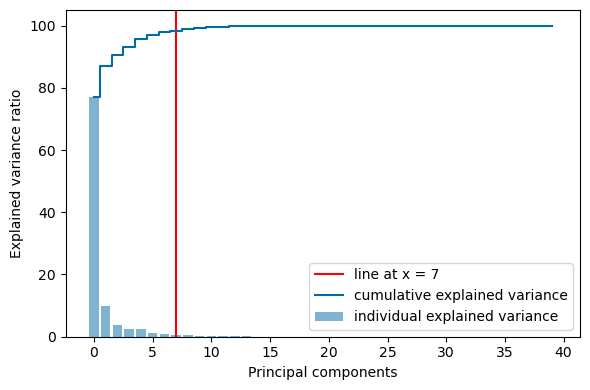

In [698]:
with plt.style.context('tableau-colorblind10'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [699]:
labels = np.unique(y, axis=0)

In [700]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

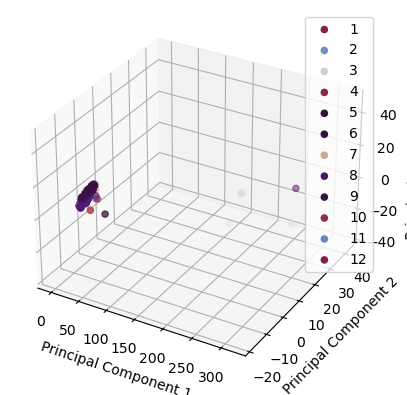

In [701]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('tableau-colorblind10'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

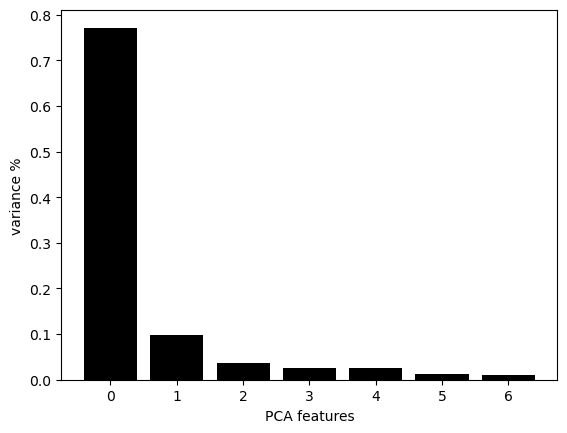

In [702]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [703]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [704]:
PCA_components.head()

,0,1,2,3,4,5,6
0,-0.270865,-0.267504,-0.379744,1.572139,-0.760546,-0.319205,0.542537
1,-0.270035,-0.268626,-0.379138,1.572316,-0.760250,-0.319173,0.543205
2,-0.247363,-0.298025,-0.364141,1.579230,-0.748602,-0.323150,0.563949
3,-0.046055,-0.753116,-0.581536,1.580909,-0.769051,-0.357399,0.778687
4,0.295144,-1.577772,0.224449,1.682219,-0.624379,-0.386487,-0.019197


### Getting the optimal number of clusters

In [705]:
# ks = range(1, max_cluster)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters: model
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(PCA_components.iloc[:,:i])
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
# plt.show()

In [706]:
# opt_cluster = 0
# for k in range(len(inertias)-1):
#     diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
#     if diff > 0.1:
#         opt_cluster += 1
#     else:
#         break
# print("Optimal number of clusters: ", opt_cluster)

In [707]:
# with plt.style.context('tableau-colorblind10'):
#     plt.figure(figsize=(6, 4))
#     plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
#     # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
#             # label='individual explained variance')
#     plt.step(range(len(inertias)), inertias, where='mid',
#              label='cumulative inertia')
    
#     plt.ylabel('Inertia')
#     plt.xlabel('Number of clusters, k')
#     plt.legend(loc='best')
#     plt.tight_layout()
# plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
# plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [708]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1, clustering_type)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1, clustering_type)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
